# Decision Trees

## Data Exploration

In [25]:
# loading the necessary modules for data exploration
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,multilabel_confusion_matrix

In [26]:
data = pd.read_csv("advertisement.csv")
data.head() # glimpse of the data

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,electronics clothing sports
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,furniture beauty
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,clothing electronics food sports
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,food
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,home


In [27]:
# No of unique values in each column
for i in data.columns:
    print(i,len(data[i].unique()))

age 47
gender 2
income 1000
education 4
married 2
children 4
city 969
occupation 11
purchase_amount 1000
most bought item 24
labels 397


In [28]:
# summary of the numerical columns
data.describe() 

,age,income,children,purchase_amount
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,40.836000,49349.796167,1.508000,101.098170
std,13.786848,9894.479148,1.129253,20.348736
min,18.000000,21908.867759,0.000000,23.482179
25%,28.000000,42577.352034,0.000000,87.699577
50%,41.000000,48993.757137,1.000000,101.587560
75%,53.000000,56566.795992,3.000000,114.718926
max,64.000000,79459.294416,3.000000,168.978628


In [29]:
# sanity check for non-null values and dtypes of the data
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               1000 non-null   int64  
 1   gender            1000 non-null   object 
 2   income            1000 non-null   float64
 3   education         1000 non-null   object 
 4   married           1000 non-null   bool   
 5   children          1000 non-null   int64  
 6   city              1000 non-null   object 
 7   occupation        1000 non-null   object 
 8   purchase_amount   1000 non-null   float64
 9   most bought item  1000 non-null   object 
 10  labels            1000 non-null   object 
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 79.2+ KB


In [30]:
# label processing : split->sort->form the tuple
data.labels = [tuple(sorted(i.split(" ")))for i in data.labels]
data

,age,gender,income,education,married,children,city,occupation,purchase_amount,most bought item,labels
0,45,Male,61271.953359,Master,False,3,Lake Sheila,Doctor,87.697118,monitor,"(clothing, electronics, sports)"
1,24,Female,53229.101074,High School,False,1,Crystalburgh,Businessman,115.135586,lipstick,"(beauty, furniture)"
2,45,Female,30066.046684,Bachelor,True,3,Margaretburgh,Engineer,101.694559,biscuits,"(clothing, electronics, food, sports)"
3,19,Male,48950.246384,PhD,False,0,Williamshaven,Lawyer,97.964887,maggi,"(food,)"
4,29,Female,44792.627094,Master,False,0,New Paul,Businessman,86.847281,carpet,"(home,)"
...,...,...,...,...,...,...,...,...,...,...,...
995,61,Male,34246.773063,Master,True,3,Solisfurt,HR,103.357441,bed,"(food, furniture)"
996,56,Female,45494.225591,Bachelor,False,0,Dawsonmouth,Engineer,85.159023,biscuits,"(clothing, food, home)"
997,64,Female,68740.442006,PhD,True,0,Lake Garyport,Salesman,101.434650,bat,"(clothing, sports)"
998,18,Female,44348.446680,Bachelor,True,0,Ericfurt,Retired,97.649988,perfume,"(beauty,)"


In [31]:
# creating a count dictionary of all the labels to know their distribution
label_dict = {}
for i in data.labels:
    label_dict[tuple(sorted(i))]=label_dict.get(tuple(i),0)+1

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

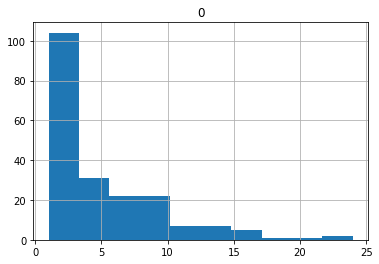

In [32]:
# sorting the labels in terms of frequency using the count dictionary
label_dist = pd.DataFrame([label_dict]).T.sort_values([0],ascending=False)
label_dist.hist()

1. The no of labels with high frequency is very low comapared to the no of labels whose frequency is low.
2. This is obvious since this is a multi label classification a pair of labels always occuring together is rare.

### Data Preprocessing 

In [33]:
'''
Based on the huge no of unique values which 
according to information theory has less information. 
we delete the column 'city'

'''
data.drop(["city"],axis=1,inplace=True)

In [34]:
# Converting Bool attribute to Nominal for smooth processing
data["married"]= data["married"].map({True: 'yes', False: 'no'}) 

In [35]:
'''
Now, All the attributes are either Nominal or numerical. 
We do one hot encoding for the categorical variables first.
We are droping the first column as it is a redundancy.
i.e. 100 -> 00 where other variables take values 10 and 01
And we store the dummies into new data frame with out 
disturbing the original data
'''
New_data = pd.get_dummies(data[['gender','education','married','occupation','most bought item','children']],drop_first=True,columns=['gender','education','married','occupation','most bought item','children'])

In [36]:
'''Now, scaling the numerical attributes 
for computational convienience etc. '''

from sklearn.preprocessing import MinMaxScaler
num_cols = data[["age","income","purchase_amount"]]
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(num_cols)
scaled_data

array([[0.58695652, 0.68397557, 0.44135056],
       [0.13043478, 0.54422243, 0.6299357 ],
       [0.58695652, 0.14173968, 0.53755525],
       ...,
       [1.        , 0.81374852, 0.53576889],
       [0.        , 0.3899116 , 0.50975683],
       [0.93478261, 0.29975826, 0.5643389 ]])

In [37]:
# Filling the new_dataframe with the scaled data and labels
New_data["age"] = scaled_data[:,0]
New_data["income"]= scaled_data[:,1]
New_data["purchase_amount"]= scaled_data[:,2]
New_data["labels"] = data["labels"]
New_data

,gender_Male,education_High School,education_Master,education_PhD,married_yes,occupation_Businessman,occupation_Doctor,occupation_Engineer,occupation_HR,occupation_Housewife,...,most bought item_shoes,most bought item_sofa,most bought item_table,children_1,children_2,children_3,age,income,purchase_amount,labels
0,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0.586957,0.683976,0.441351,"(clothing, electronics, sports)"
1,0,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0.130435,0.544222,0.629936,"(beauty, furniture)"
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0.586957,0.141740,0.537555,"(clothing, electronics, food, sports)"
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0.021739,0.469873,0.511921,"(food,)"
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0.239130,0.397630,0.435510,"(home,)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0.934783,0.214384,0.548984,"(food, furniture)"
996,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0.826087,0.409821,0.423906,"(clothing, food, home)"
997,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,0,1.000000,0.813749,0.535769,"(clothing, sports)"
998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0.000000,0.389912,0.509757,"(beauty,)"


## MultiLabel Classification

''' In this notebook, We first perform all the given tasks with respect to PowerSet Formulation Then with MultiOutPut Formulation for Better understanding'''

Build a Decision Tree Classifier Class with the Powerset Formulation which can be initialized by the following set of hyperparameters = [”max depth”, ”max features”, ”criterion”]

### Powerset Formulation 

In [38]:
''' Filtering the unique labels in each of the label tuple.
Step1 : creating the count dictionary of the unique labels
Step2 : Collecting all the keys i.e unique labels'''

class_dict = {}
for i in data.labels:
    for j in i:
        class_dict[j]=class_dict.get(j,0)+1 
unique_class = list(class_dict.keys())
unique_class

['clothing',
 'electronics',
 'sports',
 'beauty',
 'furniture',
 'food',
 'home',
 'books']

In [39]:
''' Method for generating a PowerSet of the labels.
For N no.of labels this would contain 2^N labels.
We generate all binary numbers from 0 to (2^N)-1
And pick the item at that index'''
def PowerSet(set):
    powerset = []
    pset_size = 1<<len(set) # calculating power set's size
    for i in range(0, pset_size):
        dummy = []
        for j in range(0,len(set)):
            if((i & (1 << j)) > 0):  
                dummy.append(set[j])
        powerset.append(tuple(sorted(dummy)))
    return powerset
powerset = PowerSet(unique_class) # generating the powerset

In [40]:
'''
Encoding the labels with associated index in the powerset 
and adding them to PowLabels Column in both original data and new_data
'''
PowLabels = []
for i in data.labels:
    PowLabels.append(powerset.index(tuple(i)))
data["PowLabels"] = PowLabels
New_data["PowLabels"] = PowLabels
New_data

,gender_Male,education_High School,education_Master,education_PhD,married_yes,occupation_Businessman,occupation_Doctor,occupation_Engineer,occupation_HR,occupation_Housewife,...,most bought item_sofa,most bought item_table,children_1,children_2,children_3,age,income,purchase_amount,labels,PowLabels
0,1,0,1,0,0,0,1,0,0,0,...,0,0,0,0,1,0.586957,0.683976,0.441351,"(clothing, electronics, sports)",7
1,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0.130435,0.544222,0.629936,"(beauty, furniture)",24
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0.586957,0.141740,0.537555,"(clothing, electronics, food, sports)",39
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0.021739,0.469873,0.511921,"(food,)",32
4,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0.239130,0.397630,0.435510,"(home,)",64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,1,0,1,0,0,0,1,0,...,0,0,0,0,1,0.934783,0.214384,0.548984,"(food, furniture)",48
996,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0.826087,0.409821,0.423906,"(clothing, food, home)",97
997,0,0,0,1,1,0,0,0,0,0,...,0,0,0,0,0,1.000000,0.813749,0.535769,"(clothing, sports)",5
998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0.000000,0.389912,0.509757,"(beauty,)",8


## DecisionTree with PowerSet Formulation

In [41]:
#creating data and label variables
X = New_data.drop(["labels","PowLabels"],axis=1)
y = New_data[["PowLabels"]]

In [42]:
# creating train test split
from sklearn.model_selection import train_test_split
train_data,val_data,train_label,val_label= train_test_split(X,y,test_size=0.2)

In [43]:
from sklearn.tree import DecisionTreeClassifier
power_tree = DecisionTreeClassifier()
power_tree.fit(train_data,train_label)
predictions = power_tree.predict(val_data)

In [44]:
accuracy = accuracy_score(val_label,predictions)
precision_micro = precision_score(val_label,predictions,average="micro",zero_division = 1)
recall_micro= recall_score(val_label,predictions,average="micro",zero_division = 1)
f1score_micro= f1_score(val_label,predictions,average="micro",zero_division = 1)
precision_macro= precision_score(val_label,predictions,average="macro",zero_division = 1)
recall_macro= recall_score(val_label,predictions,average="macro",zero_division = 1)
f1score_macro= f1_score(val_label,predictions,average="macro",zero_division = 1)
print(pd.DataFrame({"accuracy":accuracy,"micro_precision":precision_micro,"micro_recall":recall_micro,"micro_f1score":f1score_micro,"macro_precision":precision_macro,"macro_recall":recall_micro,"macro_f1score":f1score_micro},index=[0]).T)

                        0
accuracy         0.050000
micro_precision  0.050000
micro_recall     0.050000
micro_f1score    0.050000
macro_precision  0.425667
macro_recall     0.050000
macro_f1score    0.050000


## Hyper Parameter Tuning For Power Formulation

Report the Metrics (Accuracy, F1(micro and macro) , Confusion Matrix, Precision , Recall) for all possible triplet of hyperparamters for Powerset 

In [45]:
#Hyper Parameters for cross validation
criterion = ["gini", "entropy"]
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]

In [46]:
'''
creating a results list which encompasses all the metric 
values along with confusion matrix for each of the combination of parameters

'''
results = []
for i in criterion:
    for j in max_depth:
        for k in max_features:
            metrics = [i,j,k]
            power_tree = DecisionTreeClassifier(criterion=i, max_depth=j,max_features=k)
            power_tree.fit(train_data,train_label)
            predictions = power_tree.predict(val_data)
            accuracy = accuracy_score(val_label,predictions)
            recall = recall_score(val_label,predictions,average='micro')
            precision = precision_score(val_label,predictions,average='micro')
            f1_micro = f1_score(val_label,predictions,average='micro')
            f1_macro = f1_score(val_label,predictions,average='macro')
            cmatrix = confusion_matrix(val_label,predictions)
            metrics.extend([accuracy,recall,precision,f1_micro,f1_macro,cmatrix])
            results.append(metrics)

In [47]:
# Displaying results for all the combinations
PowerSetCV = pd.DataFrame(results,columns= ["criterion","max_depth","max_features","accuracy","recall","precision","f1_micro","f1_macro","cmatrix"])
PowerSetCV

,criterion,max_depth,max_features,accuracy,recall,precision,f1_micro,f1_macro,cmatrix
0,gini,3,3,0.035,0.035,0.035,0.035,0.002855,"[[0, 0, 0, 2, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,..."
1,gini,3,5,0.030,0.030,0.030,0.030,0.002112,"[[0, 0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,..."
2,gini,3,7,0.045,0.045,0.045,0.045,0.006082,"[[3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,gini,3,9,0.015,0.015,0.015,0.015,0.003492,"[[2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,gini,3,11,0.030,0.030,0.030,0.030,0.002110,"[[0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
5,gini,5,3,0.045,0.045,0.045,0.045,0.008745,"[[1, 1, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
6,gini,5,5,0.025,0.025,0.025,0.025,0.004911,"[[3, 2, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,..."
7,gini,5,7,0.040,0.040,0.040,0.040,0.011121,"[[2, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,..."
8,gini,5,9,0.010,0.010,0.010,0.010,0.002834,"[[0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
9,gini,5,11,0.050,0.050,0.050,0.050,0.006501,"[[3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


3.4.1.2 Rank the top 3 performing set of hyperparamters according to F1 Score.

In [48]:
'''
Picking up the top three combinations in terms of 
F1-score(i.e in order f1_micro,f1_macro)
'''
PowerSetCV.sort_values(["f1_micro","f1_macro"],ascending=False)[:3]

,criterion,max_depth,max_features,accuracy,recall,precision,f1_micro,f1_macro,cmatrix
18,gini,20,9,0.060,0.060,0.060,0.060,0.015359,"[[4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
10,gini,10,3,0.055,0.055,0.055,0.055,0.010472,"[[6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
13,gini,10,9,0.050,0.050,0.050,0.050,0.006814,"[[3, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


## K-fold Cross Validation

For the best performing model for each approach report the K Fold validation metrics for an appropriate choice of K 

In [49]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [50]:
''' Best performing model --> criterion="gini", 
max_depth=20,max_features=7, Splits = 10. 
calculated cross validation score with respect to every metric'''

cv = KFold(n_splits=10, random_state=1, shuffle=True)
power_tree = DecisionTreeClassifier(criterion="gini", max_depth=20,max_features=7)
results_dict = {}
for i in ["accuracy","precision_micro","precision_macro","recall_micro","recall_macro","f1_micro","f1_macro"]:
    scores = cross_val_score(power_tree,train_data,train_label, scoring='f1_macro', cv=cv, n_jobs=-1)
    results_dict[i]=scores
results_dict= pd.DataFrame(results_dict)

In [51]:
results_dict # Cross Validation Scores

,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,0.008855,0.002747,0.015837,0.010127,0.003663,0.010843,0.006233
1,0.033045,0.020415,0.012579,0.019318,0.001854,0.011510,0.010640
2,0.011111,0.011711,0.024638,0.022868,0.015686,0.011364,0.007246
3,0.000000,0.021875,0.019318,0.007290,0.020392,0.024623,0.023810
4,0.004704,0.040556,0.010577,0.001120,0.023896,0.001176,0.009877
5,0.013109,0.022727,0.013393,0.010989,0.000000,0.021084,0.024074
6,0.024094,0.020803,0.036008,0.004219,0.016190,0.031947,0.023611
7,0.011667,0.020022,0.003361,0.034568,0.012560,0.006734,0.020307
8,0.012658,0.007619,0.000000,0.000000,0.010526,0.000000,0.004750
9,0.008032,0.018439,0.014950,0.021176,0.001854,0.021591,0.017500


In [52]:
results_dict.describe() # Distribution summary of all the metric values 

,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.012727,0.018691,0.015066,0.013168,0.010662,0.014087,0.014805
std,0.009483,0.010216,0.010231,0.011061,0.008479,0.010430,0.007856
min,0.000000,0.002747,0.000000,0.000000,0.000000,0.000000,0.004750
25%,0.008238,0.013393,0.011078,0.004987,0.002306,0.007761,0.007904
50%,0.011389,0.020218,0.014172,0.010558,0.011543,0.011437,0.014070
75%,0.012996,0.021607,0.018448,0.020712,0.016064,0.021464,0.022785
max,0.033045,0.040556,0.036008,0.034568,0.023896,0.031947,0.024074


## MultiOutPut Formulation

This part of the notebook performs all the tasks with respect to Multi Output Formulation

In [53]:
unique_class # unique labels in the data

['clothing',
 'electronics',
 'sports',
 'beauty',
 'furniture',
 'food',
 'home',
 'books']

In [54]:
''' Crating the One Hot encoding equivalent
of the label representation using MultiLabelBinarizer'''

from sklearn.preprocessing import MultiLabelBinarizer
MopLabels= MultiLabelBinarizer().fit_transform(data["labels"])
for i in range(len(unique_class)):
    New_data["MopLabels"+str(i)] = MopLabels[:,i]
New_data

,gender_Male,education_High School,education_Master,education_PhD,married_yes,occupation_Businessman,occupation_Doctor,occupation_Engineer,occupation_HR,occupation_Housewife,...,labels,PowLabels,MopLabels0,MopLabels1,MopLabels2,MopLabels3,MopLabels4,MopLabels5,MopLabels6,MopLabels7
0,1,0,1,0,0,0,1,0,0,0,...,"(clothing, electronics, sports)",7,0,0,1,1,0,0,0,1
1,0,1,0,0,0,1,0,0,0,0,...,"(beauty, furniture)",24,1,0,0,0,0,1,0,0
2,0,0,0,0,1,0,0,1,0,0,...,"(clothing, electronics, food, sports)",39,0,0,1,1,1,0,0,1
3,1,0,0,1,0,0,0,0,0,0,...,"(food,)",32,0,0,0,0,1,0,0,0
4,0,0,1,0,0,1,0,0,0,0,...,"(home,)",64,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,0,1,0,1,0,0,0,1,0,...,"(food, furniture)",48,0,0,0,0,1,1,0,0
996,0,0,0,0,0,0,0,1,0,0,...,"(clothing, food, home)",97,0,0,1,0,1,0,1,0
997,0,0,0,1,1,0,0,0,0,0,...,"(clothing, sports)",5,0,0,1,0,0,0,0,1
998,0,0,0,0,1,0,0,0,0,0,...,"(beauty,)",8,1,0,0,0,0,0,0,0


In [55]:
# Splitting the data and labels
X = New_data.iloc[:,:-10]
y = New_data.iloc[:,-8:]

In [56]:
#train_test_splitting the data set for Mop Formulation
train_data,val_data,train_label,val_label= train_test_split(X,y,test_size=0.2)

## DecisionTree with MultiOutPut Formulation

Build a Decision Tree Classifier Class with the MultiOutput Formulation which can be initialized by the following set of hyperparameters = [”max depth”, ”max features”, ”criterion”]

In [57]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier

Multi_OP_tree = DecisionTreeClassifier()
Multi_OP_tree = MultiOutputClassifier(Multi_OP_tree).fit(train_data,train_label)
predictions = Multi_OP_tree.predict(val_data)

In [58]:
accuracy = accuracy_score(val_label,predictions)
precision_micro = precision_score(val_label,predictions,average="micro",zero_division = 1)
recall_micro= recall_score(val_label,predictions,average="micro",zero_division = 1)
f1score_micro= f1_score(val_label,predictions,average="micro",zero_division = 1)
precision_macro= precision_score(val_label,predictions,average="macro",zero_division = 1)
recall_macro= recall_score(val_label,predictions,average="macro",zero_division = 1)
f1score_macro= f1_score(val_label,predictions,average="macro",zero_division = 1)
print(pd.DataFrame({"accuracy":accuracy,"micro_precision":precision_micro,"micro_recall":recall_micro,"micro_f1score":f1score_micro,"macro_precision":precision_macro,"macro_recall":recall_micro,"macro_f1score":f1score_micro},index=[0]).T)

                        0
accuracy         0.020000
micro_precision  0.501701
micro_recall     0.522124
micro_f1score    0.511709
macro_precision  0.501880
macro_recall     0.522124
macro_f1score    0.511709


## Hyper Parameter Tuning For MultiOutPut Formulation

Report the Metrics (Accuracy, F1(micro and macro) , Confusion Matrix, Precision , Recall) for all possible triplet of hyperparamters for both Pow- erset and MultiOutput Setting.


In [59]:
criterion = ["gini", "entropy"]
max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]

In [60]:
results = []
for i in criterion:
    for j in max_depth:
        for k in max_features:
            metrics = [i,j,k]
            mop_tree = DecisionTreeClassifier(criterion=i, max_depth=j,max_features=k)
            mop_tree.fit(train_data,train_label)
            predictions = mop_tree.predict(val_data)
            accuracy = accuracy_score(val_label,predictions)
            recall = recall_score(val_label,predictions,average='micro')
            precision = precision_score(val_label,predictions,average='micro')
            f1_micro = f1_score(val_label,predictions,average='micro')
            f1_macro = f1_score(val_label,predictions,average='macro')
            cmatrix = multilabel_confusion_matrix(val_label,predictions)
            metrics.extend([accuracy,recall,precision,f1_micro,f1_macro,cmatrix])
            results.append(metrics)

In [61]:
MOPSetCV = pd.DataFrame(results,columns= ["criterion","max_depth","max_features","accuracy","recall","precision","f1_micro","f1_macro","cmatrix"])
MOPSetCV

,criterion,max_depth,max_features,accuracy,recall,precision,f1_micro,f1_macro,cmatrix
0,gini,3,3,0.015,0.051327,0.743590,0.096026,0.093673,"[[[123, 1], [76, 0]], [[120, 0], [80, 0]], [[1..."
1,gini,3,5,0.015,0.049558,1.000000,0.094435,0.088022,"[[[124, 0], [76, 0]], [[120, 0], [69, 11]], [[..."
2,gini,3,7,0.015,0.054867,0.885714,0.103333,0.095769,"[[[122, 2], [76, 0]], [[120, 0], [80, 0]], [[1..."
3,gini,3,9,0.005,0.042478,0.923077,0.081218,0.077280,"[[[124, 0], [76, 0]], [[120, 0], [80, 0]], [[1..."
4,gini,3,11,0.015,0.054867,0.968750,0.103853,0.084839,"[[[124, 0], [76, 0]], [[120, 0], [78, 2]], [[1..."
5,gini,5,3,0.015,0.069027,0.780000,0.126829,0.124031,"[[[121, 3], [75, 1]], [[118, 2], [79, 1]], [[1..."
6,gini,5,5,0.010,0.086726,0.742424,0.155309,0.131024,"[[[122, 2], [50, 26]], [[119, 1], [78, 2]], [[..."
7,gini,5,7,0.020,0.077876,0.771930,0.141479,0.136552,"[[[124, 0], [76, 0]], [[119, 1], [79, 1]], [[1..."
8,gini,5,9,0.010,0.077876,0.830189,0.142395,0.132250,"[[[122, 2], [75, 1]], [[119, 1], [69, 11]], [[..."
9,gini,5,11,0.010,0.077876,0.733333,0.140800,0.135738,"[[[122, 2], [76, 0]], [[114, 6], [79, 1]], [[1..."


rank the top 3 performing set of hyperparamters according to F1 Score.


In [62]:
MOPSetCV.sort_values(["f1_micro","f1_macro"],ascending=False)[:3]

,criterion,max_depth,max_features,accuracy,recall,precision,f1_micro,f1_macro,cmatrix
49,entropy,30,11,0.02,0.497345,0.513711,0.505396,0.503168,"[[[88, 36], [37, 39]], [[98, 22], [33, 47]], [..."
23,gini,30,9,0.03,0.509735,0.498270,0.503937,0.502867,"[[[89, 35], [39, 37]], [[92, 28], [41, 39]], [..."
48,entropy,30,9,0.06,0.497345,0.504488,0.500891,0.496696,"[[[85, 39], [34, 42]], [[94, 26], [36, 44]], [..."


## K-Fold Cross Validation

For the best performing model for each approach report the K Fold validation metrics for an appropriate choice of K 

In [63]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [64]:
cv = KFold(n_splits=10, random_state=1, shuffle=True)
mop_tree = DecisionTreeClassifier(criterion="gini", max_depth=20,max_features=7)
results_dict = {}
for i in ["accuracy","precision_micro","precision_macro","recall_micro","recall_macro","f1_micro","f1_macro"]:
    scores = cross_val_score(mop_tree,train_data,train_label, scoring='f1_macro', cv=cv, n_jobs=-1)
    results_dict[i]=scores
results_dict= pd.DataFrame(results_dict)

In [65]:
results_dict

,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
0,0.494860,0.489503,0.481132,0.498993,0.509923,0.437649,0.501230
1,0.455175,0.450884,0.449065,0.479837,0.437986,0.472188,0.431167
2,0.474620,0.445072,0.512000,0.432536,0.466567,0.490331,0.437960
3,0.475931,0.412784,0.483986,0.470193,0.479245,0.478371,0.489962
4,0.437534,0.472083,0.422184,0.376976,0.415966,0.462293,0.401198
5,0.450305,0.501122,0.527867,0.479703,0.473325,0.399977,0.458076
6,0.489537,0.483957,0.455739,0.479756,0.500075,0.455538,0.477093
7,0.445406,0.460652,0.373516,0.391072,0.450635,0.476073,0.468544
8,0.476680,0.479032,0.440523,0.459331,0.539585,0.458589,0.489591
9,0.517900,0.427252,0.423020,0.466361,0.405221,0.423565,0.427825


In [66]:
results_dict.describe()

,accuracy,precision_micro,precision_macro,recall_micro,recall_macro,f1_micro,f1_macro
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.471795,0.462234,0.456903,0.453476,0.467853,0.455457,0.458265
std,0.025010,0.028288,0.045983,0.040565,0.042056,0.027719,0.032697
min,0.437534,0.412784,0.373516,0.376976,0.405221,0.399977,0.401198
25%,0.451522,0.446525,0.427396,0.439235,0.441149,0.442122,0.432865
50%,0.475275,0.466367,0.452402,0.468277,0.469946,0.460441,0.463310
75%,0.486323,0.482726,0.483272,0.479743,0.494867,0.475102,0.486467
max,0.517900,0.501122,0.527867,0.498993,0.539585,0.490331,0.501230
